# ACTIVIDAD : Redes Convolucionales

---

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes los Simpsons.

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de la serie extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/)
Partiendo de los 18 personajes etiquetados, éstos pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [1]:
## Librerías utilizadas
import cv2
import os
import numpy as np
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import kagglehub
import shutil
import random
from sklearn.model_selection import train_test_split

Nos descargamos la carpeta de la web de Kaggle:
https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset?resource=download&select=simpsons_dataset

In [2]:
## Descargar dataset
path = kagglehub.dataset_download("alexattia/the-simpsons-characters-dataset")
print("Descargado en:", path)

## Definir rutas
source_path = os.path.join(path, "simpsons_dataset")
target_path = "./simpsons_dataset"

## Si ya existe, eliminar y copiar de nuevo
if os.path.exists(target_path):
    shutil.rmtree(target_path)
    print(f"⚠️ Carpeta existente eliminada: {target_path}")

shutil.copytree(source_path, target_path)
print(f"✅ Dataset copiado a: {target_path}")

Descargado en: /kaggle/input/the-simpsons-characters-dataset
✅ Dataset copiado a: ./simpsons_dataset


Podemos ver que los personajes están repartidos en carpetas

In [3]:
## Los personajes se encuentran en carpetas
!ls $path/simpsons_dataset


abraham_grampa_simpson	  homer_simpson        otto_mann
agnes_skinner		  kent_brockman        patty_bouvier
apu_nahasapeemapetilon	  krusty_the_clown     principal_skinner
barney_gumble		  lenny_leonard        professor_john_frink
bart_simpson		  lionel_hutz	       rainier_wolfcastle
carl_carlson		  lisa_simpson	       ralph_wiggum
charles_montgomery_burns  maggie_simpson       selma_bouvier
chief_wiggum		  marge_simpson        sideshow_bob
cletus_spuckler		  martin_prince        sideshow_mel
comic_book_guy		  mayor_quimby	       simpsons_dataset
disco_stu		  milhouse_van_houten  snake_jailbird
edna_krabappel		  miss_hoover	       troy_mcclure
fat_tony		  moe_szyslak	       waylon_smithers
gil			  ned_flanders
groundskeeper_willie	  nelson_muntz


In [4]:
dataset_dir = target_path

# Lista todos los subdirectorios en el dataset_dir, excluyendo archivos
classes = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])

# Ahora, el número de clases es simplemente la longitud de esta lista
num_classes = len(classes)
conteo_imagenes = {}

for cls in sorted(os.listdir(dataset_dir)):
    cls_path = os.path.join(dataset_dir, cls)
    if os.path.isdir(cls_path):
        imagenes = [f for f in os.listdir(cls_path) if f.endswith('.jpg')]
        conteo_imagenes[cls] = len(imagenes)

## Mostrar resultados ordenados
for cls, count in sorted(conteo_imagenes.items(), key=lambda x: x[1]):
    print(f"{cls:30s} -> {count} imágenes")

simpsons_dataset               -> 0 imágenes
lionel_hutz                    -> 3 imágenes
disco_stu                      -> 8 imágenes
troy_mcclure                   -> 8 imágenes
miss_hoover                    -> 17 imágenes
fat_tony                       -> 27 imágenes
gil                            -> 27 imágenes
otto_mann                      -> 32 imágenes
sideshow_mel                   -> 40 imágenes
agnes_skinner                  -> 42 imágenes
rainier_wolfcastle             -> 45 imágenes
cletus_spuckler                -> 47 imágenes
snake_jailbird                 -> 55 imágenes
professor_john_frink           -> 65 imágenes
martin_prince                  -> 71 imágenes
patty_bouvier                  -> 72 imágenes
ralph_wiggum                   -> 89 imágenes
carl_carlson                   -> 98 imágenes
selma_bouvier                  -> 103 imágenes
barney_gumble                  -> 106 imágenes
groundskeeper_willie           -> 121 imágenes
maggie_simpson                 -> 1

Como Lionel solo tiene tres imágenes, lo quitamos del entrenamiento

In [5]:
!rm -r ./simpsons_dataset/lionel_hutz

Ahora generaremos diferentes carpetas separando los datos de train, test y validación

In [6]:
## Crear diccionario de mapeo automáticamente
MAP_CHARACTERS = {i: cls for i, cls in enumerate(sorted(classes))}
MAP_CHARACTERS

{0: 'abraham_grampa_simpson',
 1: 'agnes_skinner',
 2: 'apu_nahasapeemapetilon',
 3: 'barney_gumble',
 4: 'bart_simpson',
 5: 'carl_carlson',
 6: 'charles_montgomery_burns',
 7: 'chief_wiggum',
 8: 'cletus_spuckler',
 9: 'comic_book_guy',
 10: 'disco_stu',
 11: 'edna_krabappel',
 12: 'fat_tony',
 13: 'gil',
 14: 'groundskeeper_willie',
 15: 'homer_simpson',
 16: 'kent_brockman',
 17: 'krusty_the_clown',
 18: 'lenny_leonard',
 19: 'lionel_hutz',
 20: 'lisa_simpson',
 21: 'maggie_simpson',
 22: 'marge_simpson',
 23: 'martin_prince',
 24: 'mayor_quimby',
 25: 'milhouse_van_houten',
 26: 'miss_hoover',
 27: 'moe_szyslak',
 28: 'ned_flanders',
 29: 'nelson_muntz',
 30: 'otto_mann',
 31: 'patty_bouvier',
 32: 'principal_skinner',
 33: 'professor_john_frink',
 34: 'rainier_wolfcastle',
 35: 'ralph_wiggum',
 36: 'selma_bouvier',
 37: 'sideshow_bob',
 38: 'sideshow_mel',
 39: 'simpsons_dataset',
 40: 'snake_jailbird',
 41: 'troy_mcclure',
 42: 'waylon_smithers'}

## Ejercicio

Utilizando Convolutional Neural Networks, entrenar al menos dos clasificadores que sean capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **90%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos, pero cuánta más información podáis aportar mejor a la hora de desarrollar vuestro modelo):

*   Análisis de los datos a utilizar. ¿Qué distribución siguen? ¿Están las clases balanceadas?
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected (sin convolución) para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.


Notas:
* Los datos están en una única carpeta, por lo que tendrás que hacer el split entre train y test
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo de al menos los dos mejores modelos obtenidos y la evaluación de los datos de test con estos modelos**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más sencillas de identificar, por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [12]:
# Definimos el tamaño que vamos a usar para nuestras imagenes
target_size_pixels = (128, 128)

def load_image(image_path, target_size):
    """
    Carga, redimensiona y normaliza una imagen desde una ruta de archivo usando OpenCV.

    Args:
        image_path (str): La ruta del archivo de imagen.
        target_size (tuple): Una tupla (ancho, alto) para el redimensionamiento.

    Returns:
        np.ndarray: La imagen preprocesada como un array NumPy normalizado.
    """
    # Cargamos la imagen
    img = cv2.imread(image_path)

    if img is None:
        print(f"Warning: Could not load image from {image_path}")
        return None

    # Convertimos a formato RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Aplicamos un resize
    img = cv2.resize(img, target_size)

    # Normalizamos
    img = img.astype('float32') / 255.0

    return img

# Listas para almacenar las imágenes preprocesadas y las etiquetas numéricas
all_images_processed = []
all_labels_numeric = []
label_to_index = {}

dataset_dir = target_path #
print("Cargando y preprocesando todas las imágenes...")
# Recopilamos y preprocesamos todas las imágenes y etiquetas
for cls in sorted(os.listdir(dataset_dir)):
    cls_path = os.path.join(dataset_dir, cls)
    if os.path.isdir(cls_path):
        images = [f for f in os.listdir(cls_path) if f.endswith('.jpg')]

        if cls not in label_to_index:
             label_to_index[cls] = len(label_to_index)

        for img_name in images:
            full_path = os.path.join(cls_path, img_name)

            processed_image = load_image(full_path, target_size_pixels)
            if processed_image is not None:
                all_images_processed.append(processed_image)

                all_labels_numeric.append(label_to_index[cls])

print("Carga y preprocesamiento completados.")

# Pasamos las listas a arrays
all_images_np = np.array(all_images_processed)
all_labels_np = np.array(all_labels_numeric)

# Dividimos los datos usando un train_test_split

train_images_np, test_images_np, train_labels_np, test_labels_np = train_test_split(
    all_images_np, all_labels_np, test_size=0.2, random_state=42, stratify=all_labels_np
)
# Miramos la forma de los arrays para comprobar que todo está correcto

print(f"Forma de los datos de entrenamiento: {train_images_np.shape}")
print(f"Forma de las etiquetas de entrenamiento: {train_labels_np.shape}")
print(f"Forma de los datos de test: {test_images_np.shape}")
print(f"Forma de las etiquetas de test: {test_labels_np.shape}")

Cargando y preprocesando todas las imágenes...
Carga y preprocesamiento completados.
Forma de los datos de entrenamiento: (16744, 128, 128, 3)
Forma de las etiquetas de entrenamiento: (16744,)
Forma de los datos de test: (4186, 128, 128, 3)
Forma de las etiquetas de test: (4186,)


Vamos a visualizar una imagen aleatoria y su índice para comprobar que efectivamente está haciendo bien el procesamiento de las imágenes y la asignación de labels.

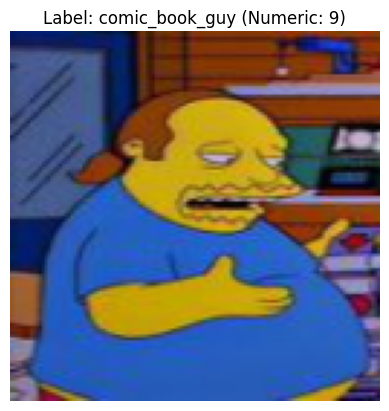

In [13]:
# Seleccionamos un índice aleatorio

index_to_label = {v: k for k, v in label_to_index.items()}

random_index = random.randint(0, len(train_images_np) - 1)

# Obtenemos una imagen preprocesada y su etiqueta numérica
image_to_show_np = train_images_np[random_index]
label_numeric_to_show = train_labels_np[random_index]

label_name_to_show = index_to_label[label_numeric_to_show]


img_to_show = image_to_show_np

# Visualizamos la imagen y su etiqueta
plt.imshow(img_to_show)
plt.title(f"Label: {label_name_to_show} (Numeric: {label_numeric_to_show})")
plt.axis('off')
plt.show()

In [14]:
# Vamos a mirar el número de clases para el desarrollo de nuestros modelos (hemos eliminado un personaje)
dataset_dir = target_path

classes = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])

# Ahora, el número de clases es simplemente la longitud de esta lista
num_classes = len(classes)

MAP_CHARACTERS = {i: cls for i, cls in enumerate(classes)}

print(f"Clases encontradas: {classes}")
print(f"Número total de clases: {num_classes}")
print(f"MAP_CHARACTERS: {MAP_CHARACTERS}")

Clases encontradas: ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'simpsons_dataset', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']
Número total de clases: 42
MAP_CHARACTERS: {0: 'abraham_grampa_simpson', 1: 'agnes_skinner', 2: 'apu_nahasapeemapetilon', 3: 'barney_gumble', 4: 'bart_simpson', 5: 'carl_carlson', 6: 'charles_montgomery_burns', 7: 'chief_wiggum', 8

In [15]:
# Definimos un early stopping para nuestros modelos

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, restore_best_weights=True)

Primero vamos a probar una CNN con dos capas y con dropout después de los poolings y la capa densa.

In [ ]:
model=Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(len(MAP_CHARACTERS), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history=model.fit(train_images_np, train_labels_np, epochs=40, validation_data=(test_images_np,  test_labels_np), callbacks=early_stopping)

Epoch 1/40
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8352 - loss: 0.4755 - val_accuracy: 0.7439 - val_loss: 1.2526
Epoch 2/40
524/524 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8378 - loss: 0.4841 - val_accuracy: 0.7418 - val_loss: 1.2880
Epoch 3/40
524/524 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8441 - loss: 0.4581 - val_accuracy: 0.7458 - val_loss: 1.2976
Epoch 4/40
524/524 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8480 - loss: 0.4658 - val_accuracy: 0.7425 - val_loss: 1.2637
Epoch 5/40
524/524 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8442 - loss: 0.4640 - val_accuracy: 0.7434 - val_loss: 1.3175
Epoch 6/40
524/524 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8458 - loss: 0.4543 - val_accuracy: 0.7375 - val_loss: 1.3005
Epoch 7/40
524/524 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8485 - loss: 0.4578 - val_accuracy: 0.7556 - val_loss: 1.3057
Epoch 8/40
524/524 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8579 - loss: 0.4223 - val_acc

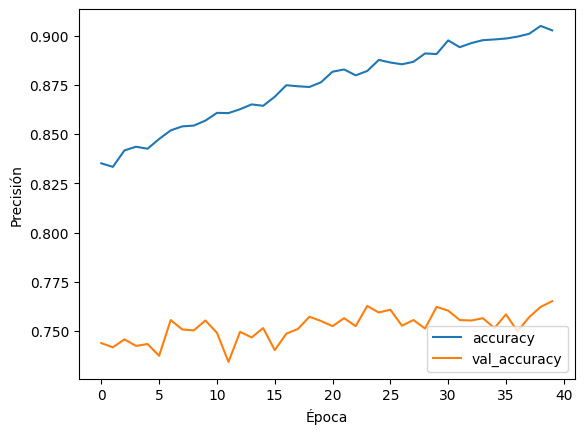

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.show()

Podemos observar que se obtiene un modelo con sobreajuste claro, además de estar muy lejos de la precisión requerida, estando la mejor época en un 76,52% en la precisión de validación.

Vamos a probar añadiendo una capa convolucional más a nuestro modelo.

In [ ]:
model5=Sequential()
model5.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.4))
model5.add(Conv2D(64, (3, 3), activation='relu'))
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.4))
model5.add(Conv2D(128, (3, 3), activation='relu'))
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.4))

model5.add(Flatten())
model5.add(Dense(256, activation='relu'))
model5.add(Dropout(0.4))
model5.add(Dense(len(MAP_CHARACTERS), activation='softmax'))

model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history5=model5.fit(train_images_np, train_labels_np, epochs=100, validation_data=(test_images_np,  test_labels_np), callbacks=early_stopping)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.1392 - loss: 3.1918 - val_accuracy: 0.4262 - val_loss: 2.1702
Epoch 2/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.4149 - loss: 2.1453 - val_accuracy: 0.5284 - val_loss: 1.6821
Epoch 3/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.5364 - loss: 1.6895 - val_accuracy: 0.6469 - val_loss: 1.3380
Epoch 4/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.6215 - loss: 1.3482 - val_accuracy: 0.6873 - val_loss: 1.1645
Epoch 5/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.6806 - loss: 1.1080 - val_accuracy: 0.7207 - val_loss: 1.0236
Epoch 6/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7263 - loss: 0.9156 - val_accuracy: 0.7370 - val_loss: 0.9569
Epoch 7/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7602 - loss: 0.7995 - val_accuracy: 0.7537 - val_loss: 0.9090
Epoch 8/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7925 - loss: 0

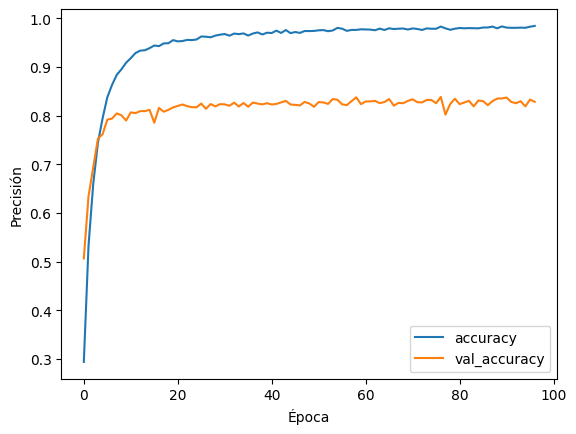

In [ ]:
plt.plot(history5.history['accuracy'], label='accuracy')
plt.plot(history5.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.show()

De nuevo nos quedamos cortos, consiguiendo una precisión en la mejor época de un 84%, y parece además existir sobreajuste, aunque no tan marcado como en el caso anterior. Aún así, esto supone una mejora clara respecto al modelo anterior y parece indicar que vamos a necesitar un modelo más complejo para llegar al 90% de precisión. Aún así vamos a probar antes si es posible llegar con solo tras capas convolucionales, ya que añadir más capas puede hacer al modelo más lento, y sería interesante conseguirlo con el menor número posible.

Primero vamos a probar bajando el número de neuronas en la capa densa a 128.

In [ ]:
model7=Sequential()
model7.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model7.add(MaxPooling2D((2, 2)))
model7.add(Dropout(0.3))
model7.add(Conv2D(64, (3, 3), activation='relu'))
model7.add(MaxPooling2D((2, 2)))
model7.add(Dropout(0.3))
model7.add(Conv2D(128, (3, 3), activation='relu'))
model7.add(MaxPooling2D((2, 2)))
model7.add(Dropout(0.3))

model7.add(Flatten())
model7.add(Dense(128, activation='relu'))
model7.add(Dropout(0.3))
model7.add(Dense(len(MAP_CHARACTERS), activation='softmax'))

model7.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history7=model7.fit(train_images_np, train_labels_np, epochs=100, validation_data=(test_images_np,  test_labels_np), callbacks=early_stopping)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.1647 - loss: 3.0486 - val_accuracy: 0.4737 - val_loss: 2.0533
Epoch 2/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.4401 - loss: 2.0498 - val_accuracy: 0.5956 - val_loss: 1.5367
Epoch 3/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5689 - loss: 1.5649 - val_accuracy: 0.6498 - val_loss: 1.3544
Epoch 4/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.6372 - loss: 1.2857 - val_accuracy: 0.6916 - val_loss: 1.1773
Epoch 5/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.6905 - loss: 1.0584 - val_accuracy: 0.7437 - val_loss: 0.9749
Epoch 6/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7338 - loss: 0.8793 - val_accuracy: 0.7496 - val_loss: 0.9534
Epoch 7/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7794 - loss: 0.7445 - val_accuracy: 0.7704 - val_loss: 0.9001
Epoch 8/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8035 - loss: 0

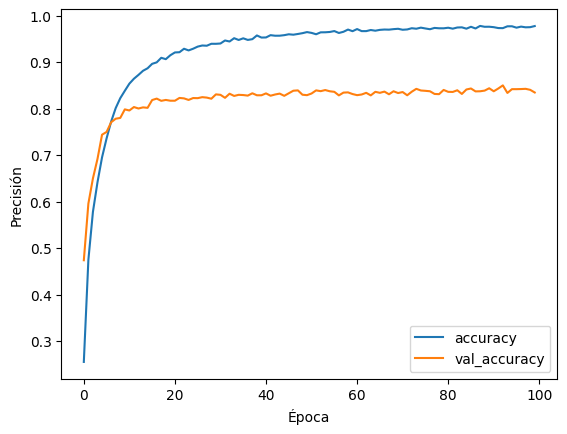

In [ ]:
plt.plot(history7.history['accuracy'], label='accuracy')
plt.plot(history7.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.show()

Esta vez se queda alrededor del 82%, por lo que bajar el número de neuronas solo ha empeorado el rendimiento del modelo.

Vamos a probar ahora con la arquitectura original de tres capas pero bajando el dropout rate a 0,3.

In [ ]:
model5=Sequential()
model5.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.3))
model5.add(Conv2D(64, (3, 3), activation='relu'))
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.3))
model5.add(Conv2D(128, (3, 3), activation='relu'))
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.3))

model5.add(Flatten())
model5.add(Dense(256, activation='relu'))
model5.add(Dropout(0.3))
model5.add(Dense(len(MAP_CHARACTERS), activation='softmax'))

model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history5=model5.fit(train_images_np, train_labels_np, epochs=100, validation_data=(test_images_np,  test_labels_np), callbacks=early_stopping)

Epoch 1/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.1867 - loss: 3.0097 - val_accuracy: 0.5067 - val_loss: 1.9413
Epoch 2/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5006 - loss: 1.8294 - val_accuracy: 0.6345 - val_loss: 1.3669
Epoch 3/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.6478 - loss: 1.2622 - val_accuracy: 0.6935 - val_loss: 1.1152
Epoch 4/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7402 - loss: 0.9075 - val_accuracy: 0.7530 - val_loss: 0.9248
Epoch 5/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7991 - loss: 0.6690 - val_accuracy: 0.7618 - val_loss: 0.9096
Epoch 6/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8393 - loss: 0.5324 - val_accuracy: 0.7919 - val_loss: 0.8175
Epoch 7/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8649 - loss: 0.4235 - val_accuracy: 0.7941 - val_loss: 0.8668
Epoch 8/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8847 - loss: 0

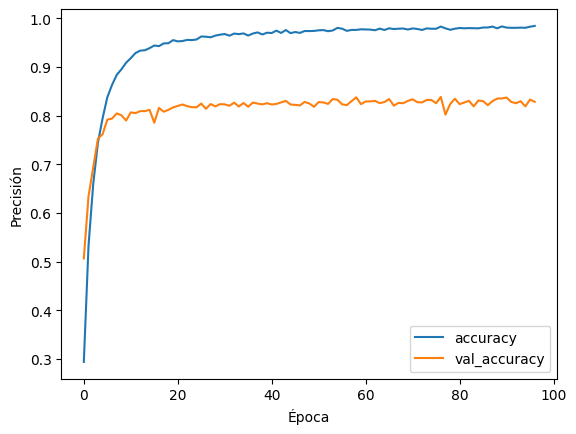

In [ ]:
plt.plot(history5.history['accuracy'], label='accuracy')
plt.plot(history5.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.show()

De nuevo no alcanzamos la precisión necesaria, obteniendo tan solo un 84%.

Vamos a definir uno de 5 capas, a ver si llega (se han desarrollado de 4 y no llegaba al 90%, no los pongo por que el trabajo está quedando ya demasiado largo)

In [ ]:
model9=Sequential()
model9.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model9.add(MaxPooling2D((2, 2)))
model9.add(Dropout(0.3))
model9.add(Conv2D(64, (3, 3), activation='relu'))
model9.add(MaxPooling2D((2, 2)))
model9.add(Dropout(0.3))
model9.add(Conv2D(128, (3, 3), activation='relu'))
model9.add(MaxPooling2D((2, 2)))
model9.add(Dropout(0.3))
model9.add(Conv2D(256, (3, 3), activation='relu'))
model9.add(MaxPooling2D((2, 2)))
model9.add(Dropout(0.3))
model9.add(Conv2D(512, (3, 3), activation='relu'))
model9.add(MaxPooling2D(2,2))
model9.add(Dropout(0.3))

model9.add(Flatten())
model9.add(Dense(256, activation='relu'))
model9.add(Dropout(0.3))
model9.add(Dense(len(MAP_CHARACTERS), activation='softmax'))

model9.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history9=model9.fit(train_images_np, train_labels_np, epochs=100, validation_data=(test_images_np,  test_labels_np), callbacks=early_stopping)

Epoch 1/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - accuracy: 0.1148 - loss: 3.1364 - val_accuracy: 0.3817 - val_loss: 2.3486
Epoch 2/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.4109 - loss: 2.1547 - val_accuracy: 0.6011 - val_loss: 1.4879
Epoch 3/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.5911 - loss: 1.4522 - val_accuracy: 0.6804 - val_loss: 1.1730
Epoch 4/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.6874 - loss: 1.1143 - val_accuracy: 0.7633 - val_loss: 0.8471
Epoch 5/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.7328 - loss: 0.9375 - val_accuracy: 0.7771 - val_loss: 0.8078
Epoch 6/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.7768 - loss: 0.7699 - val_accuracy: 0.8199 - val_loss: 0.6948
Epoch 7/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.8077 - loss: 0.6825 - val_accuracy: 0.8249 - val_loss: 0.6552
Epoch 8/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.8154 - loss: 0

En este caso sí llegamos a la precisión requerida, aunque justo, con un 90,3%.

In [ ]:
# Vamos a pritnear el classification report por clases
predictions = model9.predict(test_images_np)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_labels_np

unique_true_classes = np.unique(true_classes)


index_to_label = {v: k for k, v in label_to_index.items()}
target_names = [index_to_label[i] for i in sorted(unique_true_classes)]

# Generamos el classification report
report = classification_report(true_classes, predicted_classes, target_names=target_names, labels=sorted(unique_true_classes))

print(report)

131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.94      0.86      0.90       183
           agnes_skinner       0.55      0.67      0.60         9
  apu_nahasapeemapetilon       0.89      0.94      0.91       125
           barney_gumble       0.64      0.67      0.65        21
            bart_simpson       0.88      0.88      0.88       268
            carl_carlson       0.67      0.80      0.73        20
charles_montgomery_burns       0.89      0.85      0.87       239
            chief_wiggum       0.96      0.95      0.95       197
         cletus_spuckler       0.67      0.67      0.67         9
          comic_book_guy       0.90      0.83      0.86        94
               disco_stu       1.00      0.50      0.67         2
          edna_krabappel       0.82      0.95      0.88        91
                fat_tony       0.80      0.80      0.80         5
                     gil       0.

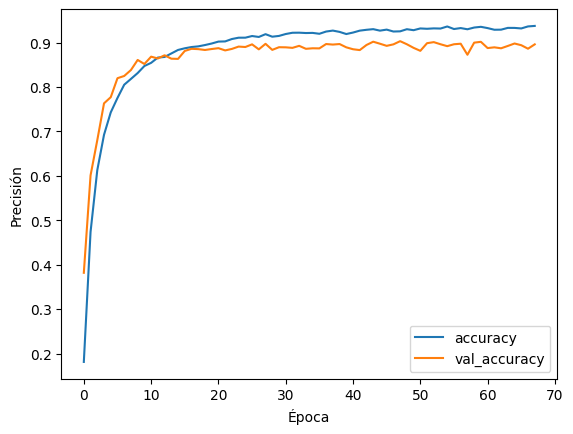

In [ ]:
plt.plot(history9.history['accuracy'], label='accuracy')
plt.plot(history9.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.show()

Podemos ver que clasifica bien la mayoría de personajes, siendo als únicas excepciones personajes que apenas están presentes en el conjunto de imágenes, y solo haciendo un mal desempeño en aquellos cuya representacion en el dataset de unas 20.000 fotos es de alrededor de la decena.

In [ ]:
model10=Sequential()
model10.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model10.add(BatchNormalization())
model10.add(MaxPooling2D((2, 2)))
model10.add(Dropout(0.3))
model10.add(Conv2D(64, (3, 3), activation='relu'))
model10.add(BatchNormalization())
model10.add(MaxPooling2D((2, 2)))
model10.add(Dropout(0.3))
model10.add(Conv2D(128, (3, 3), activation='relu'))
model10.add(BatchNormalization())
model10.add(MaxPooling2D((2, 2)))
model10.add(Dropout(0.3))
model10.add(Conv2D(256, (3, 3), activation='relu'))
model10.add(BatchNormalization())
model10.add(MaxPooling2D((2, 2)))
model10.add(Dropout(0.3))
model10.add(Conv2D(512, (3, 3), activation='relu'))
model10.add(BatchNormalization())
model10.add(MaxPooling2D((2, 2)))
model10.add(Dropout(0.3))

model10.add(Flatten())
model10.add(Dense(256, activation='relu'))
model10.add(BatchNormalization())
model10.add(Dropout(0.3))
model10.add(Dense(len(MAP_CHARACTERS), activation='softmax'))

model10.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history10=model10.fit(train_images_np, train_labels_np, epochs=100, validation_data=(test_images_np,  test_labels_np), callbacks=early_stopping)

Epoch 1/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.2767 - loss: 3.1271 - val_accuracy: 0.3734 - val_loss: 2.3165
Epoch 2/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5790 - loss: 1.5438 - val_accuracy: 0.6756 - val_loss: 1.1933
Epoch 3/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.7103 - loss: 1.0522 - val_accuracy: 0.6307 - val_loss: 1.3742
Epoch 4/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.7663 - loss: 0.8369 - val_accuracy: 0.7542 - val_loss: 0.8538
Epoch 5/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.8078 - loss: 0.6709 - val_accuracy: 0.7974 - val_loss: 0.7237
Epoch 6/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.8334 - loss: 0.5750 - val_accuracy: 0.8390 - val_loss: 0.5750
Epoch 7/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.8562 - loss: 0.4953 - val_accuracy: 0.8598 - val_loss: 0.5200
Epoch 8/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.8794 - loss: 0

En este caso obtenemos una mejora del modelo, llegando a los 93% de precisión. Además, si nos fijamos en el classification_report, este modelo hace un muy buen trabajo con la mayoría de las clases minoritarias, a diferencia del anterior.

In [ ]:
# De la misma manera vamos a hacer el classification_report para este modelo.

predictions = model10.predict(test_images_np)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_labels_np

unique_true_classes = np.unique(true_classes)

index_to_label = {v: k for k, v in label_to_index.items()}
target_names = [index_to_label[i] for i in sorted(unique_true_classes)]

report = classification_report(true_classes, predicted_classes, target_names=target_names, labels=sorted(unique_true_classes))

print(report)

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.89      0.91      0.90       183
           agnes_skinner       0.88      0.78      0.82         9
  apu_nahasapeemapetilon       0.94      0.94      0.94       125
           barney_gumble       0.81      0.62      0.70        21
            bart_simpson       0.91      0.90      0.90       268
            carl_carlson       0.77      0.85      0.81        20
charles_montgomery_burns       0.95      0.92      0.93       239
            chief_wiggum       0.94      0.95      0.95       197
         cletus_spuckler       0.88      0.78      0.82         9
          comic_book_guy       0.92      0.90      0.91        94
               disco_stu       1.00      0.50      0.67         2
          edna_krabappel       0.83      0.97      0.89        91
                fat_tony       1.00      1.00      1.00         5
                     gil       0.5

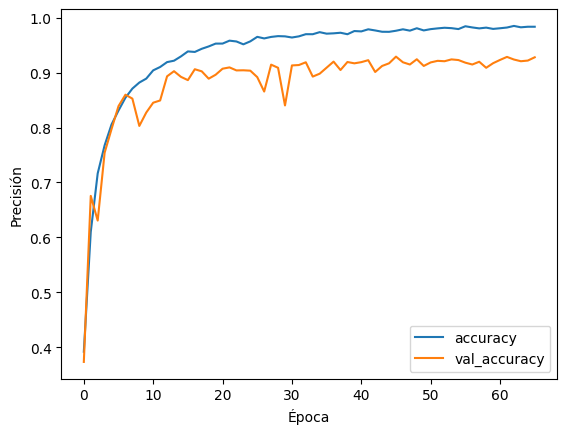

In [ ]:
plt.plot(history10.history['accuracy'], label='accuracy')
plt.plot(history10.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.show()

Vamos a comparar el desempeño de estas redes con una red fully connected sin capas convolucionales.

In [17]:
model_ff = Sequential()
model_ff.add(Flatten(input_shape=(128, 128, 3)))
model_ff.add(Dense(256, activation='relu'))
model_ff.add(Dense(128, activation='relu'))
model_ff.add(Dense(num_classes, activation='softmax'))

model_ff.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
history_ff=model_ff.fit(train_images_np, train_labels_np, epochs=100, validation_data=(test_images_np,  test_labels_np), callbacks=early_stopping)

Epoch 1/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.1500 - loss: 5.5961 - val_accuracy: 0.2542 - val_loss: 2.7065
Epoch 2/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2791 - loss: 2.6584 - val_accuracy: 0.3397 - val_loss: 2.4337
Epoch 3/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3256 - loss: 2.4745 - val_accuracy: 0.2602 - val_loss: 2.7675
Epoch 4/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3692 - loss: 2.3193 - val_accuracy: 0.3629 - val_loss: 2.3337
Epoch 5/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3899 - loss: 2.2296 - val_accuracy: 0.3679 - val_loss: 2.3529
Epoch 6/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4015 - loss: 2.1299 - val_accuracy: 0.3552 - val_loss: 2.3558
Epoch 7/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4218 - loss: 2.0602 - val_accuracy: 0.3767 - val_loss: 2.2610
Epoch 8/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4245 - loss: 2.0309 - val_acc

Podemos ver como el rendimiento es mucho peor que el de las CNNs, incluso comparándolo con el peor de los modelos convolucionales, siendo la precisión de este un 76%, comparado con menos del 50% para la feedforward.